In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 320

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =1

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/trp75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

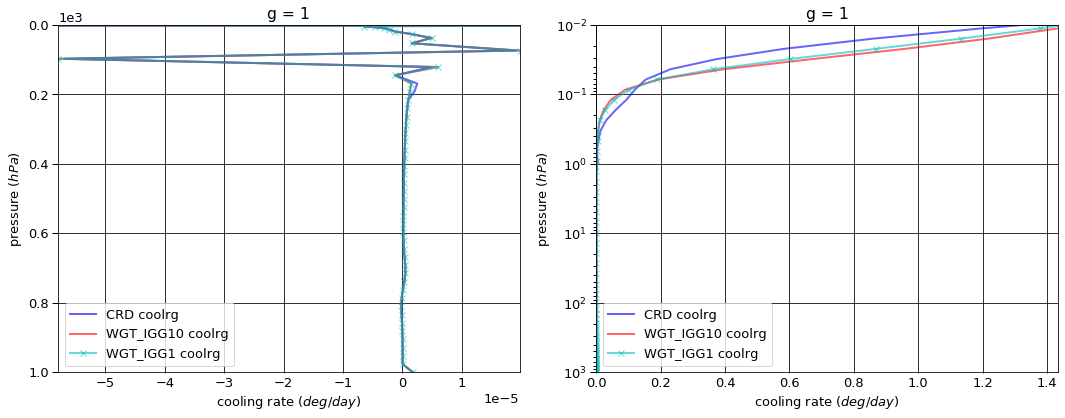

# Figure: cooling rate g-group 2

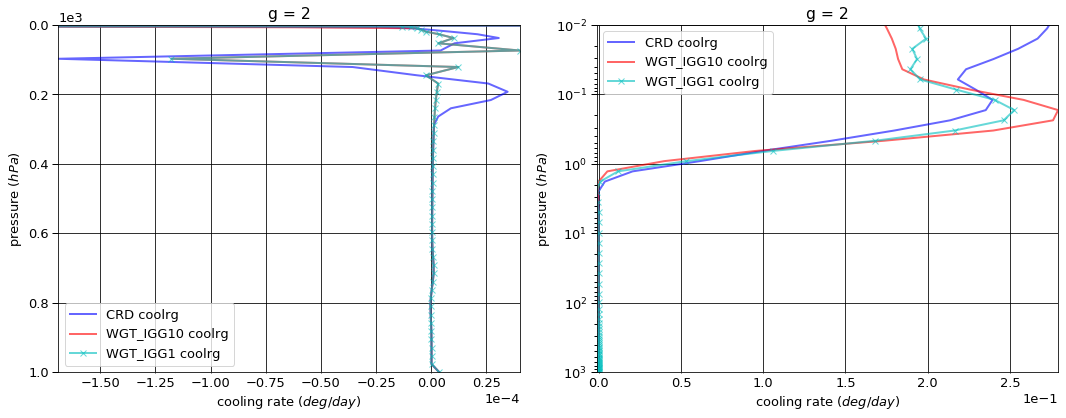

# Figure: cooling rate g-group 3

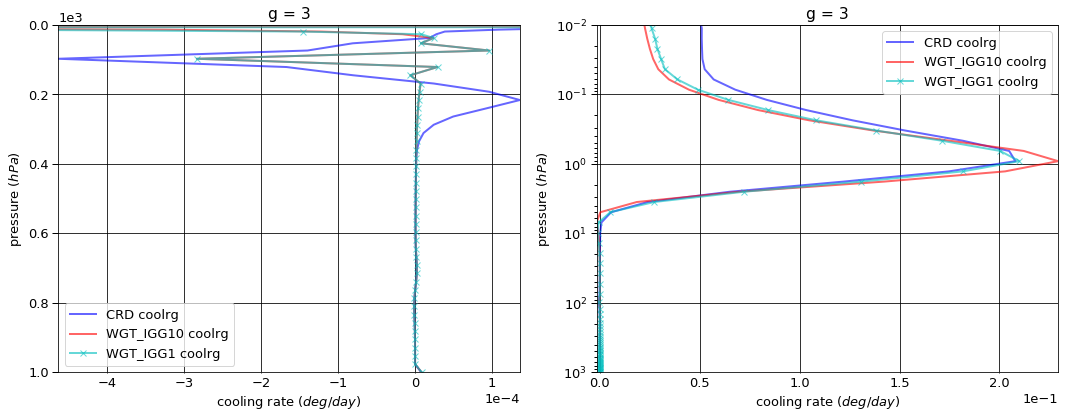

# Figure: cooling rate g-group 4

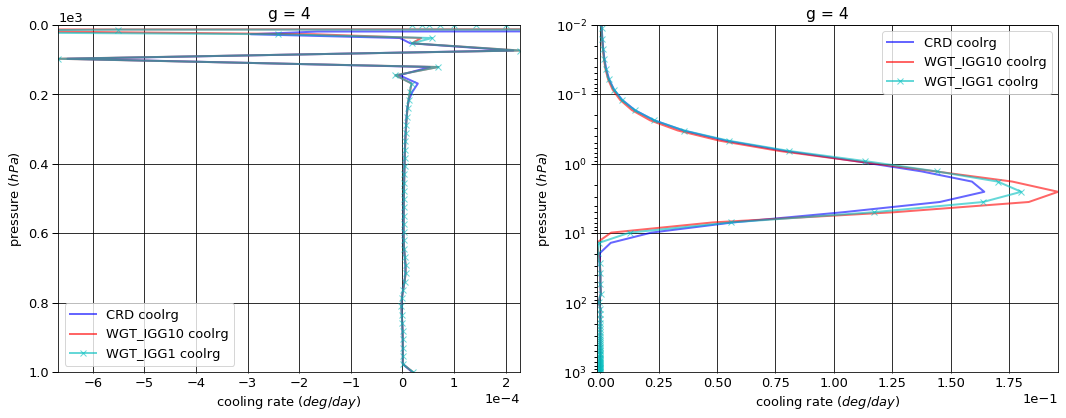

# Figure: cooling rate g-group 5

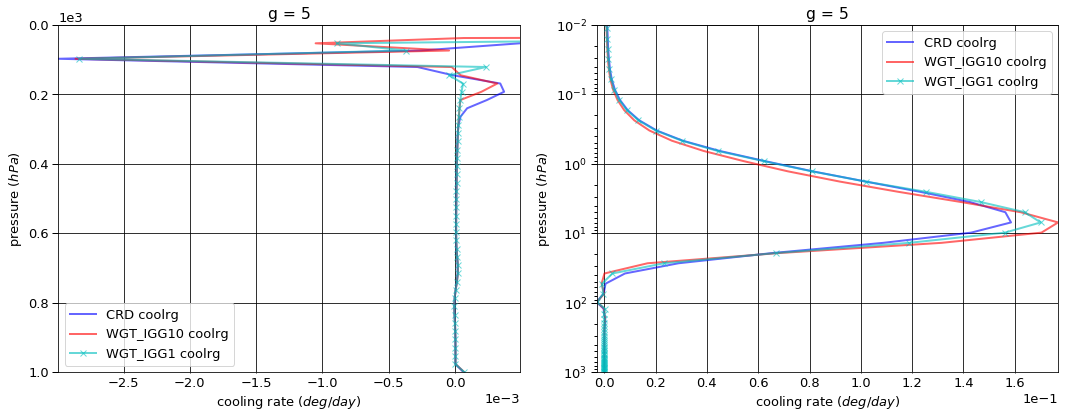

# Figure: cooling rate g-group 6

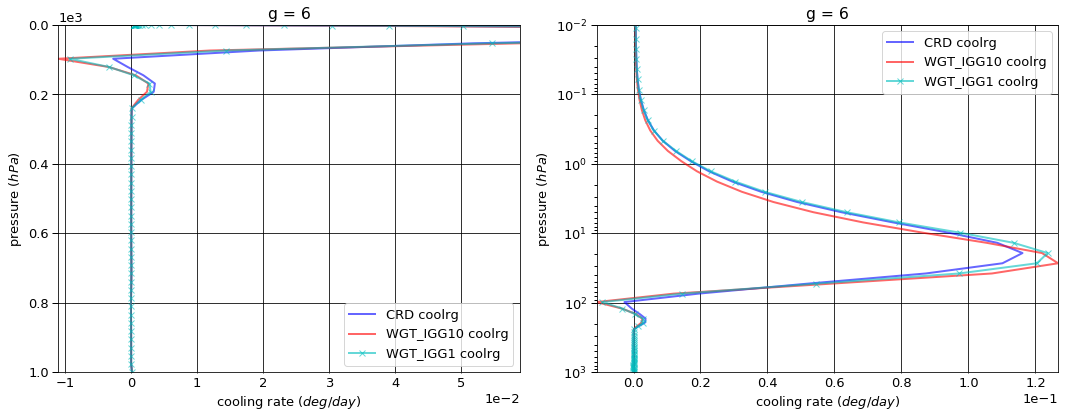

# Figure: cooling rate g-group 7

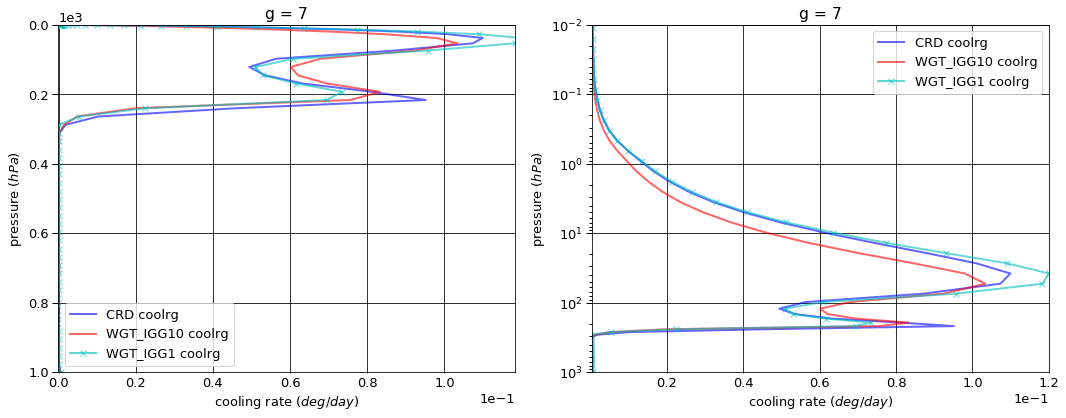

# Figure: cooling rate g-group 8

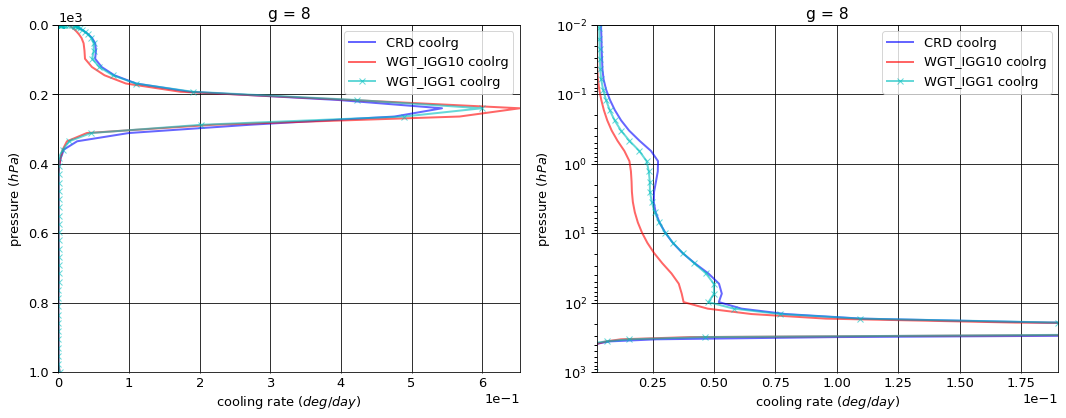

# Figure: cooling rate g-group 9

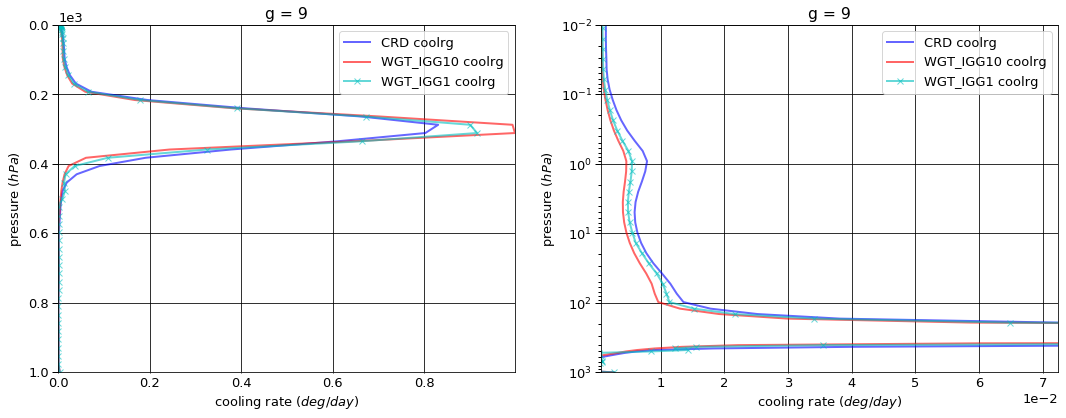

# Figure: cooling rate g-group 10

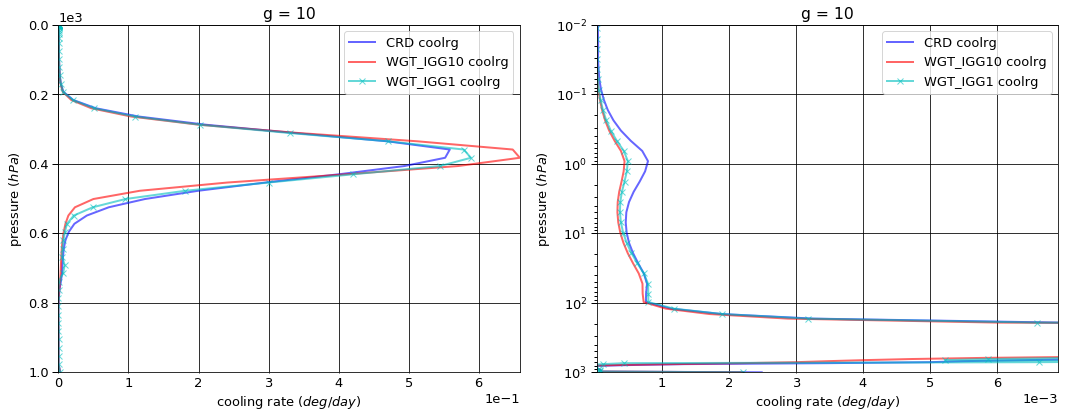

# Figure: cooling rate g-group total

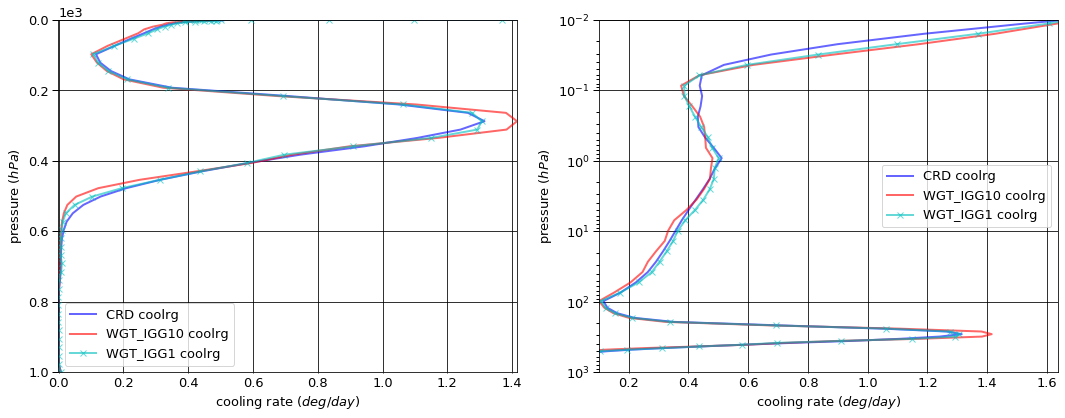

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007391   0.000000  -0.007391
   1013.0   76     -0.012879   0.012875  -0.000005
2  0.0      1      -0.018362   0.000000  -0.018362
   1013.0   76     -0.026409   0.026399  -0.000010
3  0.0      1      -0.049055   0.000000  -0.049055
   1013.0   76     -0.062841   0.062818  -0.000023
4  0.0      1      -0.109393   0.000000  -0.109393
   1013.0   76     -0.147289   0.147236  -0.000054
5  0.0      1      -0.326128   0.000000  -0.326128
   1013.0   76     -0.492728   0.492549  -0.000179
6  0.0      1      -0.669647   0.000000  -0.669647
   1013.0   76     -1.156223   1.155804  -0.000419
7  0.0      1      -2.203863   0.000000  -2.203863
   1013.0   76     -4.020720   4.019259  -0.001461
8  0.0      1      -6.992305   0.000000  -6.992305
   1013.0   76    -11.540410  11.536187  -0.004222
9  0.0      1     -12.572986   0.000000 -12.572986
   1013.0   76    -19.016930  19.009785  -0.007144
10 0.0      1     -11.383402   0.000000 -11.383402
   1013.0   76    -16.387955  16.381036  -0.006919


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007173   0.000000  -0.007173
   1013.0   76     -0.013060   0.013055  -0.000005
2  0.0      1      -0.018291   0.000000  -0.018291
   1013.0   76     -0.026538   0.026527  -0.000010
3  0.0      1      -0.049958   0.000000  -0.049958
   1013.0   76     -0.063844   0.063819  -0.000025
4  0.0      1      -0.111018   0.000000  -0.111018
   1013.0   76     -0.150325   0.150267  -0.000058
5  0.0      1      -0.326604   0.000000  -0.326604
   1013.0   76     -0.503177   0.502983  -0.000194
6  0.0      1      -0.662755   0.000000  -0.662755
   1013.0   76     -1.181411   1.180955  -0.000457
7  0.0      1      -2.103564   0.000000  -2.103564
   1013.0   76     -4.105498   4.103912  -0.001586
8  0.0      1      -6.915744   0.000000  -6.915744
   1013.0   76    -11.754895  11.750353  -0.004542
9  0.0      1     -12.459682   0.000000 -12.459682
   1013.0   76    -19.200936  19.193516  -0.007420
10 0.0      1     -11.322528   0.000000 -11.322528
   1013.0   76    -15.864701  15.858570  -0.006130


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007187   0.000000  -0.007187
   1013.0   76     -0.013060   0.013055  -0.000005
2  0.0      1      -0.018454   0.000000  -0.018454
   1013.0   76     -0.026538   0.026527  -0.000010
3  0.0      1      -0.049616   0.000000  -0.049616
   1013.0   76     -0.063844   0.063819  -0.000025
4  0.0      1      -0.110381   0.000000  -0.110381
   1013.0   76     -0.150325   0.150267  -0.000058
5  0.0      1      -0.325926   0.000000  -0.325926
   1013.0   76     -0.503177   0.502983  -0.000194
6  0.0      1      -0.663964   0.000000  -0.663964
   1013.0   76     -1.181411   1.180955  -0.000457
7  0.0      1      -2.115222   0.000000  -2.115222
   1013.0   76     -4.105498   4.103912  -0.001586
8  0.0      1      -6.842103   0.000000  -6.842103
   1013.0   76    -11.754895  11.750353  -0.004542
9  0.0      1     -12.474746   0.000000 -12.474746
   1013.0   76    -19.200936  19.193516  -0.007420
10 0.0      1     -11.377079   0.000000 -11.377079
   1013.0   76    -15.864701  15.858570  -0.006130


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1      0.000218  0.000000  2.177740e-04
   1013.0   76    -0.000181  0.000180 -2.661890e-07
2  0.0      1      0.000071  0.000000  7.078200e-05
   1013.0   76    -0.000129  0.000129 -1.998020e-07
3  0.0      1     -0.000904  0.000000 -9.035960e-04
   1013.0   76    -0.001002  0.001001 -1.498300e-06
4  0.0      1     -0.001625  0.000000 -1.625460e-03
   1013.0   76    -0.003036  0.003031 -4.568054e-06
5  0.0      1     -0.000476  0.000000 -4.759600e-04
   1013.0   76    -0.010449  0.010434 -1.549676e-05
6  0.0      1      0.006892  0.000000  6.892200e-03
   1013.0   76    -0.025188  0.025151 -3.754122e-05
7  0.0      1      0.100299  0.000000  1.002993e-01
   1013.0   76    -0.084778  0.084653 -1.252493e-04
8  0.0      1      0.076562  0.000000  7.656170e-02
   1013.0   76    -0.214485  0.214166 -3.198846e-04
9  0.0      1      0.113304  0.000000  1.133040e-01
   1013.0   76    -0.184006  0.183731 -2.753475e-04
10 0.0      1      0.060874  0.000000  6.087400e-02
   1013.0   76     0.523254 -0.522466  7.890831e-04


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1      0.000204  0.000000  2.039819e-04
   1013.0   76    -0.000181  0.000180 -2.661890e-07
2  0.0      1     -0.000092  0.000000 -9.224700e-05
   1013.0   76    -0.000129  0.000129 -1.998020e-07
3  0.0      1     -0.000562  0.000000 -5.615980e-04
   1013.0   76    -0.001002  0.001001 -1.498300e-06
4  0.0      1     -0.000988  0.000000 -9.884200e-04
   1013.0   76    -0.003036  0.003031 -4.568054e-06
5  0.0      1      0.000202  0.000000  2.022800e-04
   1013.0   76    -0.010449  0.010434 -1.549676e-05
6  0.0      1      0.005683  0.000000  5.682660e-03
   1013.0   76    -0.025188  0.025151 -3.754122e-05
7  0.0      1      0.088641  0.000000  8.864130e-02
   1013.0   76    -0.084778  0.084653 -1.252493e-04
8  0.0      1      0.150203  0.000000  1.502029e-01
   1013.0   76    -0.214485  0.214166 -3.198846e-04
9  0.0      1      0.098240  0.000000  9.824000e-02
   1013.0   76    -0.184006  0.183731 -2.753475e-04
10 0.0      1      0.006323  0.000000  6.323000e-03
   1013.0   76     0.523254 -0.522466  7.890831e-04

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer          
1  0.000312    1      3.956958
   1001.112500 75     0.000002
2  0.000312    1      0.253618
   1001.112500 75     0.000004
3  0.000312    1      0.043352
   1001.112500 75     0.000008
4  0.000312    1      0.000021
   1001.112500 75     0.000019
5  0.000312    1      0.000765
   1001.112500 75     0.000064
6  0.000312    1      0.000476
   1001.112500 75     0.000151
7  0.000312    1      0.000463
   1001.112500 75     0.000526
8  0.000312    1      0.003377
   1001.112500 75     0.001521
9  0.000312    1      0.001155
   1001.112500 75     0.002573
10 0.000312    1      0.000034
   1001.112500 75     0.002492


WGT_IGG10


coolrg
g  pressure    layer          
1  0.000312    1      1.932542
   1001.112500 75     0.000002
2  0.000312    1      0.143452
   1001.112500 75     0.000004
3  0.000312    1      0.016874
   1001.112500 75     0.000009
4  0.000312    1      0.000018
   1001.112500 75     0.000021
5  0.000312    1      0.000516
   1001.112500 75     0.000070
6  0.000312    1      0.000409
   1001.112500 75     0.000164
7  0.000312    1      0.000290
   1001.112500 75     0.000571
8  0.000312    1      0.001864
   1001.112500 75     0.001636
9  0.000312    1      0.000606
   1001.112500 75     0.002672
10 0.000312    1      0.000021
   1001.112500 75     0.002207


WGT_IGG1


coolrg
g  pressure    layer          
1  0.000312    1      2.371472
   1001.112500 75     0.000002
2  0.000312    1      0.166719
   1001.112500 75     0.000004
3  0.000312    1      0.019813
   1001.112500 75     0.000009
4  0.000312    1      0.000019
   1001.112500 75     0.000021
5  0.000312    1      0.000573
   1001.112500 75     0.000070
6  0.000312    1      0.000485
   1001.112500 75     0.000164
7  0.000312    1      0.000403
   1001.112500 75     0.000571
8  0.000312    1      0.002772
   1001.112500 75     0.001636
9  0.000312    1      0.000741
   1001.112500 75     0.002672
10 0.000312    1      0.000024
   1001.112500 75     0.002207


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.024416e+00
   1001.112500 75     9.561900e-08
2  0.000312    1     -1.101661e-01
   1001.112500 75     7.176140e-08
3  0.000312    1     -2.647881e-02
   1001.112500 75     5.383024e-07
4  0.000312    1     -3.822277e-06
   1001.112500 75     1.640743e-06
5  0.000312    1     -2.482727e-04
   1001.112500 75     5.567310e-06
6  0.000312    1     -6.703610e-05
   1001.112500 75     1.348551e-05
7  0.000312    1     -1.729962e-04
   1001.112500 75     4.499730e-05
8  0.000312    1     -1.512424e-03
   1001.112500 75     1.149062e-04
9  0.000312    1     -5.491955e-04
   1001.112500 75     9.889600e-05
10 0.000312    1     -1.300781e-05
   1001.112500 75    -2.843934e-04


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.585486e+00
   1001.112500 75     9.561900e-08
2  0.000312    1     -8.689902e-02
   1001.112500 75     7.176140e-08
3  0.000312    1     -2.353907e-02
   1001.112500 75     5.383024e-07
4  0.000312    1     -2.620143e-06
   1001.112500 75     1.640743e-06
5  0.000312    1     -1.914686e-04
   1001.112500 75     5.567310e-06
6  0.000312    1      8.945140e-06
   1001.112500 75     1.348551e-05
7  0.000312    1     -6.017674e-05
   1001.112500 75     4.499730e-05
8  0.000312    1     -6.047076e-04
   1001.112500 75     1.149062e-04
9  0.000312    1     -4.137199e-04
   1001.112500 75     9.889600e-05
10 0.000312    1     -1.054258e-05
   1001.112500 75    -2.843934e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.332532,0.000000,-34.332532
1013.0,76,-52.864385,52.843947,-0.020437



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33.977317,0.000000,-33.977317
1013.0,76,-52.864385,52.843956,-0.020428



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33.984678,0.000000,-33.984678
1013.0,76,-52.864385,52.843956,-0.020428



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.552147e-01,0.000000,0.355215
1013.0,76,-8.200001e-08,0.000009,0.000009



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.478539e-01,0.000000,0.347854
1013.0,76,-8.200001e-08,0.000009,0.000009


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,4.260219
1001.112500,75,0.007360



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.096591
1001.112500,75,0.007355



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.563021
1001.112500,75,0.007355



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.163628
1001.112500,75,-0.000004



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.697198
1001.112500,75,-0.000004


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000266,0.000247
2,0.000500,0.000502
3,0.001391,0.001208
4,0.003156,0.002844
5,0.011406,0.009518
6,0.025547,0.022348
7,0.093094,0.077661
8,0.256141,0.222359
9,0.383641,0.363211


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.096164e-16
2,1.309690e-17
3,1.564810e-18
4,4.601703e-18
5,5.682550e-19
6,6.154553e-19
7,7.853808e-20
8,1.002222e-20
9,1.278933e-21


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.096164e-16,NaN,0.000266,0.000247,0.000266,0.000247,1.0
2,1.309690e-17,0.119479,0.000500,0.000502,0.000766,0.000749,1.0
3,1.564810e-18,0.119479,0.001391,0.001208,0.002156,0.001957,1.0
4,4.601703e-18,2.940742,0.003156,0.002844,0.005313,0.004800,30.0
5,5.682550e-19,0.123488,0.011406,0.009518,0.016719,0.014319,30.0
6,6.154553e-19,1.083062,0.025547,0.022348,0.042266,0.036667,300.0
7,7.853808e-20,0.127610,0.093094,0.077661,0.135359,0.114328,300.0
8,1.002222e-20,0.127610,0.256141,0.222359,0.391500,0.336687,300.0
9,1.278933e-21,0.127610,0.383641,0.363211,0.775141,0.699898,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     3.502283e-16  1.441720e-16   2.429239  1.425308e-02
      2  0.000312     1.257029e-17  7.876641e-18   1.595894  6.424426e-04
      3  0.000312     1.123519e-18  4.052121e-19   2.772670  4.294865e-05
      4  0.000312     2.344890e-22  2.343562e-22   1.000566  1.621867e-08
      5  0.000312     2.427704e-21  1.345175e-21   1.804750  1.155485e-07
      6  0.000312     5.921957e-22  4.420078e-22   1.339786  3.370164e-08
      7  0.000312     1.362400e-22  5.351266e-23   2.545939  7.137236e-09
      8  0.000312     4.284946e-22  3.446322e-23  12.433389  1.874326e-08
      9  0.000312     8.291438e-23  3.937343e-24  21.058459  3.551254e-09
      10 0.000312     3.849205e-24  3.457661e-25  11.132396  1.693737e-10
2     1  0.000750     3.508380e-16  1.444635e-16   2.428558  5.751735e-03
      2  0.000750     1.265289e-17  7.918748e-18   1.597840  2.602795e-04
      3  0.000750     1.128297e-18  4.084925e-19   2.762099  1.740309e-05
      4  0.000750     4.684425e-22  4.683016e-22   1.000301  1.305283e-08
      5  0.000750     2.464970e-21  1.379842e-21   1.786414  4.752928e-08
      6  0.000750     5.974308e-22  4.464217e-22   1.338266  1.370445e-08
      7  0.000750     1.375292e-22  5.423290e-23   2.535899  2.904371e-09
      8  0.000750     4.301722e-22  3.466161e-23  12.410624  7.579799e-09
      9  0.000750     8.324924e-23  3.962673e-24  21.008355  1.436280e-09
      10 0.000750     3.890062e-24  3.479373e-25  11.180353  6.892890e-11
3     1  0.001052     3.520656e-16  1.449647e-16   2.428629  8.094257e-03
      2  0.001052     1.281301e-17  7.990320e-18   1.603567  3.688479e-04
      3  0.001052     1.136303e-18  4.128416e-19   2.752394  2.461871e-05
      4  0.001052     6.301807e-22  6.300303e-22   1.000239  2.462634e-08
      5  0.001052     2.501773e-21  1.411536e-21   1.772376  6.795304e-08
      6  0.001052     6.039612e-22  4.512281e-22   1.338483  1.942700e-08
      7  0.001052     1.394987e-22  5.501172e-23   2.535800  4.131412e-09
      8  0.001052     4.334473e-22  3.492365e-23  12.411282  1.071070e-08
      9  0.001052     8.392639e-23  3.998558e-24  20.989164  2.030659e-09
      10 0.001052     3.972876e-24  3.511841e-25  11.312801  9.865773e-11
4     1  0.001476     3.533062e-16  1.454903e-16   2.428383  1.139595e-02
      2  0.001476     1.297835e-17  8.065638e-18   1.609092  5.230643e-04
      3  0.001476     1.144860e-18  4.177270e-19   2.740690  3.486566e-05
      4  0.001476     8.570004e-22  8.568327e-22   1.000196  4.698435e-08
      5  0.001476     2.547269e-21  1.451752e-21   1.754617  9.762273e-08
      6  0.001476     6.114260e-22  4.569347e-22   1.338104  2.759581e-08
      7  0.001476     1.416608e-22  5.594391e-23   2.532193  5.887500e-09
      8  0.001476     4.368513e-22  3.521809e-23  12.404172  1.514440e-08
      9  0.001476     8.462404e-23  4.038122e-24  20.956287  2.872614e-09
      10 0.001476     4.058872e-24  3.547399e-25  11.441827  1.413133e-10
5     1  0.002070     3.545432e-16  1.460411e-16   2.427694  1.604200e-02
      2  0.002070     1.314745e-17  8.144968e-18   1.614180  7.418152e-04
      3  0.002070     1.154016e-18  4.232972e-19   2.726254  4.941322e-05
      4  0.002070     1.175136e-21  1.174936e-21   1.000170  9.036452e-08
      5  0.002070     2.604538e-21  1.503615e-21   1.732184  1.410377e-07
      6  0.002070     6.201083e-22  4.638523e-22   1.336866  3.927825e-08
      7  0.002070     1.440502e-22  5.708189e-23   2.523571  8.402994e-09
      8  0.002070     4.403555e-22  3.555401e-23  12.385536  2.141338e-08
      9  0.002070     8.533389e-23  4.082263e-24  20.903577  4.063205e-09
      10 0.002070     4.147078e-24  3.586704e-25  11.562364  2.023952e-10
6     1  0.002904     3.557760e-16  1.466271e-16   2.426400  2.258687e-02
      2  0.002904     1.332121e-17  8.229909e-18   1.618633  1.052610e-03
      3  0.002904     1.163969e

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
